# Свертки в Keras

Будем использовать Fashion MNIST

In [ ]:
!pip install -q tensorflow==2.1

ERROR: Could not find a version that satisfies the requirement tensorflow==2.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1)
ERROR: No matching distribution found for tensorflow==2.1


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
print("We're using TF", tf.__version__)
import keras
import keras.models as M
import keras.layers as L
import keras.backend as K
print("We are using Keras", keras.__version__)
import pandas as pd

We're using TF 2.15.0
We are using Keras 2.15.0


In [ ]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-32f372ea-099d-8842-cf22-5aebb3d6428f)


# Загрузим данные

Классы:
```
0 T-shirt/top
1 Trouser
2 Pullover
3 Dress
4 Coat
5 Sandal
6 Shirt
7 Sneaker
8 Bag
9 Ankle boot
```




In [ ]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
print(x_train.shape)
print(x_val.shape)
print (y_train[:10])
print (y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[9 0 0 3 0 2 7 2 5 5]
[9 2 1 1 6 1 4 6 5 7]


Пример кусочка картинки:


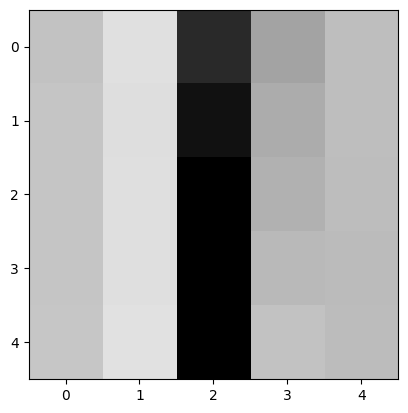

Пример картинки:


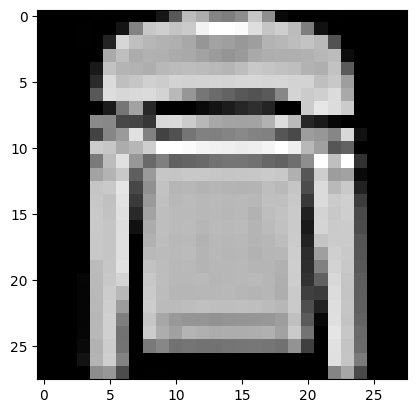

y_train [shape (60000,)] 10 примеров:
 [9 0 0 3 0 2 7 2 5 5]


In [ ]:
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))
print("Пример кусочка картинки:")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")
plt.show()
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")
plt.show()
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])

In [ ]:
# one-hot encode для ответов
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:5], y_train[:5])

(60000, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] [9 0 0 3 0]


# Собираем модель

Будем как и в предыдущем модуле минимизировать кросс-энтропию.

In [ ]:
K.clear_session()

# в этот раз используем картинку как вход без вытягивания в вектор!

model = M.Sequential()
model.add(L.Conv2D(16, kernel_size=3, strides=1, padding='same', input_shape=(28, 28, 1)))
model.add(L.MaxPool2D())
model.add(L.Conv2D(32, kernel_size=3, strides=1, padding='same'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(64, kernel_size=3, strides=1, padding='same'))
model.add(L.MaxPool2D())
model.add(L.Flatten())
model.add(L.Dense(10, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0

In [ ]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # так будет быстрее, позже узнаем что это :)
    metrics=['accuracy']  # выводим процент правильных ответов
)

In [ ]:
# центрируем и нормируем, так сети будет проще учиться (позже узнаем почему :)
x_train_float = x_train.astype(np.float) / 255 - 0.5
x_val_float = x_val.astype(np.float) / 255 - 0.5

In [ ]:
model.fit(
    x_train_float[:, :, :, np.newaxis],
    y_train_oh,
    batch_size=32,
    epochs=5,
    validation_data=(x_val_float[:, :, :, np.newaxis], y_val_oh)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 13s 216us/sample - loss: 0.4638 - accuracy: 0.8340 - val_loss: 0.3690 - val_accuracy: 0.8677
Epoch 2/5
60000/60000 [==============================] - 7s 115us/sample - loss: 0.3194 - accuracy: 0.8863 - val_loss: 0.3175 - val_accuracy: 0.8866
Epoch 3/5
60000/60000 [==============================] - 7s 115us/sample - loss: 0.2778 - accuracy: 0.9014 - val_loss: 0.3086 - val_accuracy: 0.8883
Epoch 4/5
60000/60000 [==============================] - 7s 115us/sample - loss: 0.2498 - accuracy: 0.9099 - val_loss: 0.2808 - val_accuracy: 0.8999
Epoch 5/5
60000/60000 [==============================] - 7s 114us/sample - loss: 0.2277 - accuracy: 0.9177 - val_loss: 0.2976 - val_accuracy: 0.8951
